# Problem generator for Blocksworld

In [20]:
import os
import sys

ROOT = os.path.dirname(os.path.dirname(os.path.abspath('.')))
print("ROOT", ROOT)

ROOT /home/merlo/Documents/Aalto/Thesis/open-world-symbolic-planner


In [21]:
sys.path.append(ROOT)

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Since we have a custom domain (which considers column order), we also need to write a customized script to generate new problems. 

For a problem, we will need to:

- Sample the allowed blocks (number and colors) from a given set
- Sample the number and name of columns from a given set
- Generate a random initial state
- Generate a random goal state
- Ensure the problem is solvable. Ideally, we can also request a specific (or somewhat specific) plan length to customize the difficulty.

In [23]:
blocks_config = {
    'colors': ['R', 'G', 'B', 'Y', 'O', 'P'],
    'num': 6,
}

col_config = {
    'names': ['C1', 'C2', 'C3'],
}

problem_config = {
    'problem_name': 'test_gen',
    'blocks_config': blocks_config,
    'col_config': col_config,
    'max_init_col_height': 2,
}

In [24]:
import random

random.seed(0)

In [25]:
def sample_blocks(blocks_config):
    return random.sample(blocks_config['colors'], k=blocks_config['num'])

sampled_blocks = sample_blocks(problem_config['blocks_config'])
sampled_blocks

['Y', 'P', 'R', 'G', 'B', 'O']

In [26]:
# Let's begin the problem string generation, this will later be a single function but for the notebook we do it step by step

problem_str = f"""

(define (problem {problem_config['problem_name']})
  (:domain blocksworld)
  
  (:objects 
    {" ".join(sampled_blocks)} - block
    {" ".join(problem_config['col_config']['names'])} - column
  )
"""

print(problem_str)



(define (problem test_gen)
  (:domain blocksworld)
  
  (:objects 
    Y P R G B O - block
    C1 C2 C3 - column
  )



## Initial state generation

One way to generate an initial state where each block is either alone or on top of another block is to use networkx to generate a graph. A node can be a block or a column, and an edge can be a block on top of another block or a block in a column (only if it is the bottom block).

In [27]:
import networkx as nx

def generate_state_graph(sampled_blocks, col_config, max_init_col_height):

    # Initialize the graph with a node for each sampled block and a node for each column
    G = nx.DiGraph()
    G.add_nodes_from(sampled_blocks, type='block')
    G.add_nodes_from(col_config['names'], type='column')
    
    # For each block, add an edge either to the column or to another block
    # Make sure that the column has enough space -> each column can have at most max_init_col_height blocks
    
    for block in sampled_blocks:
        # Sample a column with enough space
        col = random.choice(col_config['names'])
        while G.in_degree(col) >= max_init_col_height:
            col = random.choice(col_config['names'])
        G.add_edge(block, col)
        print(f"Block {block} added to column {col}")
        
        # If there are other blocks in the column, we need to add an edge to the top block (the one with 0 in-degree)
        blocks_in_col = [n for n in G.predecessors(col)]
        if len(blocks_in_col) == 1:
            continue # Only the block itself is in the column
        if blocks_in_col:
            top_block = blocks_in_col[-2] # The last block is the one we just added
            assert G.in_degree(top_block) == 0, f"Top block {top_block} has in-degree {G.in_degree(top_block)}"
            if top_block != block:
                G.add_edge(block, top_block)
                print(f"Block {block} added on top of block {top_block}")
    
    return G

In [28]:
G = generate_state_graph(sampled_blocks, problem_config['col_config'], problem_config['max_init_col_height'])

Block Y added to column C2
Block P added to column C2
Block P added on top of block Y
Block R added to column C3
Block G added to column C1
Block B added to column C3
Block B added on top of block R
Block O added to column C1
Block O added on top of block G


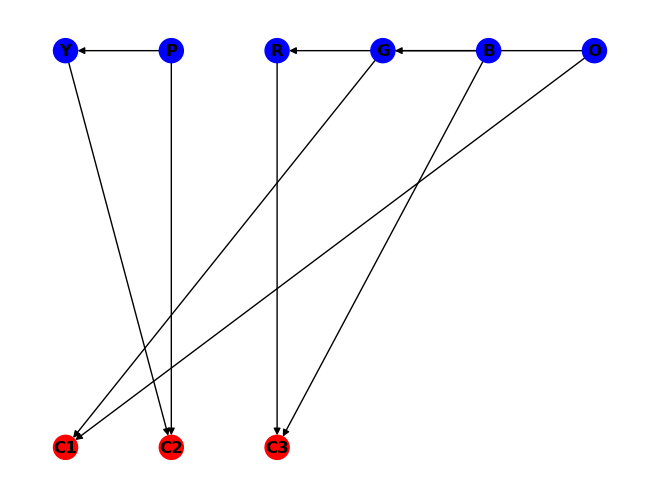

In [29]:
import matplotlib.pyplot as plt

def draw_graph(G):
    pos = {node: (i, -1) for i, node in enumerate(col_config['names']) if G.nodes[node]['type'] == 'column'}    
    block_pos = {node: (i, 0) for i, node in enumerate([n for n in G.nodes if G.nodes[n]['type'] == 'block'])}
    pos.update(block_pos)
    
    colors = ['blue' if G.nodes[n]['type'] == 'block' else 'red' for n in G.nodes]
    
    nx.draw(G, pos, with_labels=True, font_weight='bold', node_color=colors)
    plt.show()

draw_graph(G)

Now let's translate the graph to predicates:

- `on(b1, b2)`: block `b1` is on top of block `b2` if there is an edge between two blocks
- `clear(b1)`: block `b1` is clear if it is the topmost (in-degree is 0)
- `inColumn(b1, c1)`: block `b1` is in column `c1` if there is an edge between block `b1` and column `c1`
- `rightOf(c1, c2)`, `leftOf(c1, c2)` depends on column order, for now we use the one given by the input and don't sample.

In [30]:
def graph_to_predicate_list(G, col_config):
    predicates = {
        'on': [],
        'clear': [],
        'inColumn': [],
        'rightOf': [],
        'leftOf': [],
    }
    
    for node in G.nodes:
        if G.nodes[node]['type'] == 'block':
            if G.in_degree(node) == 0:
                predicates['clear'].append(f'{node}')
            else:
                predecessors = list(G.predecessors(node))
                predicates['on'].append((predecessors[0], node))

            for col in col_config['names']:
                if G.has_edge(node, col):
                    predicates['inColumn'].append((node, col))
                    break
                
    # Column order
    for i in range(len(col_config['names']) - 1):
        predicates['leftOf'].append((col_config['names'][i], col_config['names'][i+1]))
        predicates['rightOf'].append((col_config['names'][i+1], col_config['names'][i]))
        
    return predicates

In [31]:
predicates = graph_to_predicate_list(G, problem_config['col_config'])
predicates

{'on': [('P', 'Y'), ('B', 'R'), ('O', 'G')],
 'clear': ['P', 'B', 'O'],
 'inColumn': [('Y', 'C2'),
  ('P', 'C2'),
  ('R', 'C3'),
  ('G', 'C1'),
  ('B', 'C3'),
  ('O', 'C1')],
 'rightOf': [('C2', 'C1'), ('C3', 'C2')],
 'leftOf': [('C1', 'C2'), ('C2', 'C3')]}

In [32]:
problem_str += "\n  (:init"

for predicate in predicates:
    for args in predicates[predicate]:
        problem_str += f"\n    ({predicate} {' '.join(args)})"
    problem_str += "\n"
    
problem_str += "  )"
print(problem_str)



(define (problem test_gen)
  (:domain blocksworld)
  
  (:objects 
    Y P R G B O - block
    C1 C2 C3 - column
  )

  (:init
    (on P Y)
    (on B R)
    (on O G)

    (clear P)
    (clear B)
    (clear O)

    (inColumn Y C2)
    (inColumn P C2)
    (inColumn R C3)
    (inColumn G C1)
    (inColumn B C3)
    (inColumn O C1)

    (rightOf C2 C1)
    (rightOf C3 C2)

    (leftOf C1 C2)
    (leftOf C2 C3)
  )


## Goal state generation

For the goal state, a simple way is to randomly shuffle the graph so that the blocks are in a different configuration. Then, we can add the goal predicates based on the new graph to the PDDL problem and it will be complete, so we can use the planner to check if the problem is solvable. If not, we can shuffle the graph again.

Block Y added to column C2
Block P added to column C1
Block R added to column C1
Block R added on top of block P
Block G added to column C3
Block B added to column C2
Block B added on top of block Y
Block O added to column C3
Block O added on top of block G


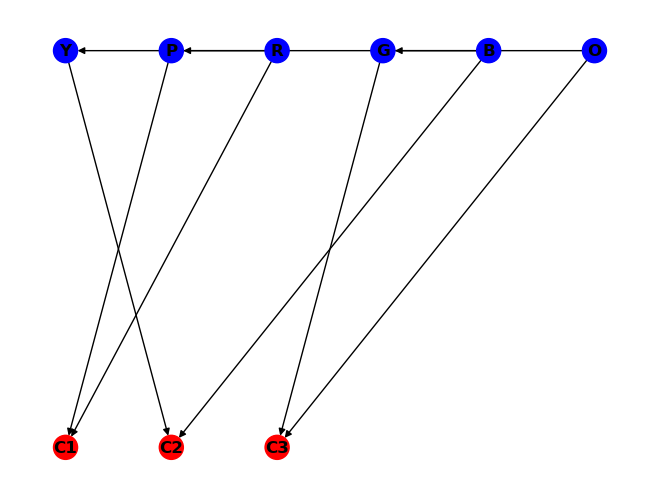

In [33]:
goal_G = generate_state_graph(sampled_blocks, problem_config['col_config'], len(sampled_blocks)) # All blocks in the same column 
while G == goal_G:
    goal_G = generate_state_graph(sampled_blocks, problem_config['col_config'], len(sampled_blocks))
    
draw_graph(goal_G)

In [34]:
goal_predicates = graph_to_predicate_list(goal_G, problem_config['col_config'])
# Discard rightOf and leftOf predicates as they can't change
goal_predicates.pop('rightOf')
goal_predicates.pop('leftOf')
goal_predicates

{'on': [('B', 'Y'), ('R', 'P'), ('O', 'G')],
 'clear': ['R', 'B', 'O'],
 'inColumn': [('Y', 'C2'),
  ('P', 'C1'),
  ('R', 'C1'),
  ('G', 'C3'),
  ('B', 'C2'),
  ('O', 'C3')]}

In [35]:
problem_str += "\n  (:goal"
problem_str += "\n    (and"

for predicate in goal_predicates:
    for args in goal_predicates[predicate]:
        problem_str += f"\n      ({predicate} {' '.join(args)})"
    problem_str += "\n"
    
problem_str += "    )"
problem_str += "\n  )"
problem_str += "\n)"

print(problem_str)



(define (problem test_gen)
  (:domain blocksworld)
  
  (:objects 
    Y P R G B O - block
    C1 C2 C3 - column
  )

  (:init
    (on P Y)
    (on B R)
    (on O G)

    (clear P)
    (clear B)
    (clear O)

    (inColumn Y C2)
    (inColumn P C2)
    (inColumn R C3)
    (inColumn G C1)
    (inColumn B C3)
    (inColumn O C1)

    (rightOf C2 C1)
    (rightOf C3 C2)

    (leftOf C1 C2)
    (leftOf C2 C3)
  )
  (:goal
    (and
      (on B Y)
      (on R P)
      (on O G)

      (clear R)
      (clear B)
      (clear O)

      (inColumn Y C2)
      (inColumn P C1)
      (inColumn R C1)
      (inColumn G C3)
      (inColumn B C2)
      (inColumn O C3)
    )
  )
)


In [36]:
from unified_planning.shortcuts import *
from unified_planning.io import PDDLReader

DOMAIN_FILE = os.path.join(ROOT, 'data', 'planning', 'bird-blocksworld', 'domain.pddl')
problem_path = os.path.join(os.curdir, problem_config['problem_name'] + '.pddl')

with open(problem_path, 'w') as f:
    f.write(problem_str)
    
reader = PDDLReader()
problem = reader.parse_problem(DOMAIN_FILE, problem_path)
problem

problem name = test_gen

types = [block, column]

fluents = [
  bool on[b1=block, b2=block]
  bool incolumn[b=block, c=column]
  bool clear[b=block]
  bool rightof[c1=column, c2=column]
  bool leftof[c1=column, c2=column]
]

actions = [
  action moveblock(block b1, column c1) {
    preconditions = [
      (clear(b1) and (not incolumn(b1, c1)))
    ]
    effects = [
      incolumn(b1, c1) := true
      clear(b1) := true
      forall column c2 if incolumn(b1, c2) then incolumn(b1, c2) := false
      forall block b2 if on(b1, b2) then on(b1, b2) := false
      forall block b2 if on(b1, b2) then clear(b2) := true
      forall block b2 if (incolumn(b2, c1) and clear(b2) and (not (b2 == b1))) then on(b1, b2) := true
      forall block b2 if (incolumn(b2, c1) and clear(b2) and (not (b2 == b1))) then clear(b2) := false
    ]
  }
]

objects = [
  block: [y, p, r, g, b, o]
  column: [c1, c2, c3]
]

initial fluents default = [
  bool on[b1=block, b2=block] := false
  bool incolumn[b=block, c=colu

In [37]:
with OneshotPlanner(problem_kind=problem.kind) as planner:
    result = planner.solve(problem)
    if result.status == up.engines.PlanGenerationResultStatus.SOLVED_SATISFICING:
        print("Fast Downward returned: %s" % result.plan)
    else:
        print("No plan found.")

  *** Credits ***
  * In operation mode `OneshotPlanner` at line 1 of `/tmp/ipykernel_347050/4173542664.py`, you are using the following planning engine:
  * Engine name: Fast Downward
  * Developers:  Uni Basel team and contributors (cf. https://github.com/aibasel/downward/blob/main/README.md)
  * Description: Fast Downward is a domain-independent classical planning system.

Fast Downward returned: SequentialPlan:
    moveblock(p, c1)
    moveblock(b, c2)
    moveblock(p, c3)
    moveblock(p, c2)
    moveblock(o, c3)
    moveblock(p, c1)
    moveblock(p, c3)
    moveblock(g, c3)
    moveblock(g, c2)
    moveblock(p, c1)
    moveblock(g, c3)
    moveblock(g, c1)
    moveblock(o, c2)
    moveblock(g, c3)
    moveblock(g, c2)
    moveblock(r, c1)
    moveblock(g, c3)
    moveblock(o, c3)


Padding 0.4
column_x {0: -5.6, 1: 0.0, 2: 5.6}


CUDA cuInit: Unknown error


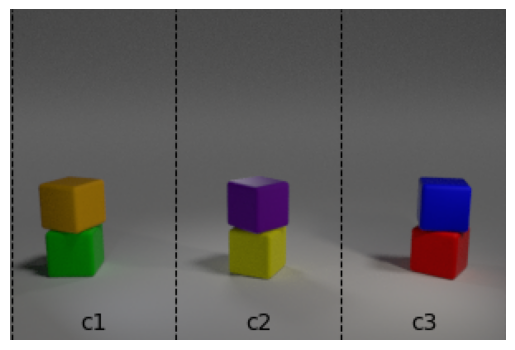

In [38]:
from viplan.planning.blocksworld_simulator import BlocksworldSimulator
from viplan.code_helpers import get_logger

def plot_image(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

logger = get_logger(log_level='info')
env = BlocksworldSimulator(problem, root_path=ROOT, logger=logger, seed=1)
plot_image(env.render())